## Libs

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

In [104]:
url = "https://raw.githubusercontent.com/gustavo-candidoo/data-science/main/imoveis.csv"
houses = pd.read_csv(url)
houses.head()

,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654


## Explorando

In [105]:
houses.shape

(11657, 8)

In [106]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   11657 non-null  object
 1   district  11657 non-null  object
 2   area      11657 non-null  int64 
 3   bedrooms  11657 non-null  int64 
 4   garage    11657 non-null  int64 
 5   type      11657 non-null  object
 6   rent      11657 non-null  int64 
 7   total     11657 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 728.7+ KB


In [107]:
houses.nunique()

address     5348
district    1199
area         381
bedrooms       7
garage         7
type           4
rent        1662
total       5571
dtype: int64

In [108]:
houses.type.unique()

array(['Studio e kitnet', 'Apartamento', 'Casa em condomínio', 'Casa'],
      dtype=object)

In [109]:
houses = houses.drop(columns=["address", "district"])

In [110]:
houses['bedroom_and_garage'] = np.where((houses['bedrooms']> 0) & (houses['garage'] > 0), 1, 0)

In [111]:
houses.head()

,area,bedrooms,garage,type,rent,total,bedroom_and_garage
0,21,1,0,Studio e kitnet,2400,2939,0
1,15,1,1,Studio e kitnet,1030,1345,1
2,18,1,0,Apartamento,4000,4661,0
3,56,2,2,Casa em condomínio,1750,1954,1
4,19,1,0,Studio e kitnet,4000,4654,0


In [112]:
houses['extra_cost'] = houses['total'] - houses['rent']

# Modelo Preditivo

In [113]:
from sklearn.model_selection import train_test_split

X = houses.drop(['rent', 'total'], axis=1)
y = houses['rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9325, 6), (2332, 6), (9325,), (2332,))

In [115]:
categorical_features = ['type']
numerical_features = ['area', 'bedrooms', 'garage', 'bedroom_and_garage', 'extra_cost']

In [116]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first')
X_train_categorical = ohe.fit_transform(X_train[categorical_features])
X_test_categorical = ohe.transform(X_test[categorical_features])

In [117]:
X_train_categorical

<9325x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3572 stored elements in Compressed Sparse Row format>

In [118]:
X_train_processed = pd.concat([pd.DataFrame(X_train_categorical.toarray()), X_train[numerical_features].reset_index()], axis=1)
X_test_processed = pd.concat([pd.DataFrame(X_test_categorical.toarray()), X_test[numerical_features].reset_index()], axis=1)

X_train_processed.shape, X_test_processed.shape

((9325, 9), (2332, 9))

### Método sem Pipeline e sem ColumTransformer

In [128]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [120]:
xgb = XGBRegressor()

xgb.fit(X_train_processed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [121]:
y_pred = xgb.predict(X_test_processed)

In [122]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2270349.4141143654


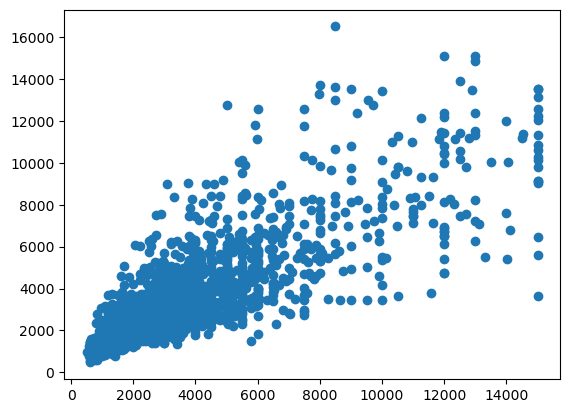

In [123]:
plt.scatter(y_test, y_pred)

### Com ColumnTransformer

In [125]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

categorical_features = ['type']
numerical_features = ['area', 'bedrooms', 'garage', 'bedroom_and_garage', 'extra_cost']

transformations = [
    ('ohe', OneHotEncoder(drop='first'), categorical_features), 
    ('scaler', StandardScaler(), numerical_features)
]

preprocessor = ColumnTransformer(transformers=transformations)

In [126]:
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_test_transformed = preprocessor.transform(X_test)

In [127]:
xgb.fit(X_train_transformed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [132]:
y_pred = xgb.predict(X_test_transformed)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")


mape = np.mean(np.abs((y_test - y_pred) / y_test) * 100)
print(f"MAPE: {mape}")

RMSE: 1566.4138408166932
MAE: 964.1446120456807
MAPE: 30.637892063485978


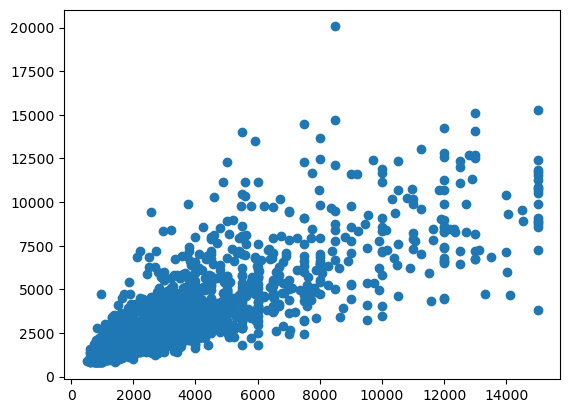

In [134]:
plt.scatter(y_test, y_pred)
plt.show()